In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing import preprocess_data, preprocess_gt_data
from models.MLP import MLP
from models.KalmanFilterMLP import KalmanFilterMLP
from models.KF import KF
from models.LinearModels import OLS, RidgeRegression

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
SEED = 0
EPS = 1e-6

TEST_ALL_GT_DATA = False # If set to True, the model will be trained on all available data and predictions will be made for all available GT data

TRAIN_PROPORTION = 0.9 if not TEST_ALL_GT_DATA else 1
PAST_GDPS = [] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
PAST_GTS = [0] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
DROP_ORIGINAL_GTS = 0 in PAST_GTS
MODE = 'yearly-log-diff' # None | "pct" | "diff"

In [50]:
data, all_gdps = load_data()
gt_data = load_gt_data()

print(f"Data shape: {data.shape}")

X_train, y_train, X_valid, y_valid, country_train, country_valid,  X_means, X_stds, y_mean, y_std, min_date = preprocess_data(
    data=data, 
    epsilon=EPS, 
    train_pct=TRAIN_PROPORTION, 
    mode=MODE, all_gdps=all_gdps, 
    past_gdp_lags=PAST_GDPS, 
    all_gts=gt_data, 
    past_gt_lags=PAST_GTS,
    drop_original_gts=DROP_ORIGINAL_GTS
)

if TEST_ALL_GT_DATA:
    X_valid, country_valid = preprocess_gt_data(gt_data, EPS, X_means, X_stds, min_date=min_date)

X_train[country_train == "Switzerland"].head()

Data shape: (550, 98)
X_train shape : (469, 102)
X_valid shape : (53, 102)
y_train shape : (469,)
y_valid shape : (53,)


,date,Expense_average_lag_0,Research_and_development_average_lag_0,Capital_expenditure_average_lag_0,Business_average_lag_0,Cost_average_lag_0,Tax_average_lag_0,Financial_capital_average_lag_0,Investment_average_lag_0,Gross_domestic_product_average_lag_0,...,Artificial_intelligence_average_lag_0,International_Financial_Reporting_Standards_average_lag_0,Employment_average_lag_0,country_Canada,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States
5,-1.773609,0.595259,-0.260692,-2.601662,0.822671,-1.239437,1.267611,-1.24455,1.688694,-1.063983,...,0.236627,0.521773,0.578485,-0.414887,-0.414887,-0.364096,-0.414887,2.405142,-0.414887,-0.414887
11,-1.722300,0.635278,-7.900754,-2.601662,0.749320,-1.153234,-0.672714,-1.24455,1.515256,-1.183822,...,-0.013540,-1.199530,0.688722,-0.414887,-0.414887,-0.364096,-0.414887,2.405142,-0.414887,-0.414887
14,-1.670992,0.148602,-7.900754,-2.601662,0.772318,-1.328563,-1.047477,-1.24455,1.772445,-1.183822,...,0.236627,0.739223,0.688722,-0.414887,-0.414887,-0.364096,-0.414887,2.405142,-0.414887,-0.414887
18,-1.620242,0.148602,-0.699168,-2.601662,0.708835,-1.718753,-0.873009,-1.24455,0.726144,-1.307467,...,0.236627,0.898486,0.364804,-0.414887,-0.414887,-0.364096,-0.414887,2.405142,-0.414887,-0.414887
26,-1.570049,0.245552,-1.710026,-2.601662,0.779785,-1.239437,0.767417,-1.24455,1.190590,-1.183822,...,0.460410,0.799928,0.591592,-0.414887,-0.414887,-0.364096,-0.414887,2.405142,-0.414887,-0.414887


In [51]:
y_train[country_train == "Switzerland"].head().to_frame()

,GDP
5,-0.474170
11,-0.466772
14,0.134046
18,0.801901
26,1.558607


In [52]:
model = MLP(seed=SEED, n_models=5)

# Fit and predict on training and validation data
print("Training MLP")

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

Training MLP


# Model performances on year-on-year log-diff

MLP :


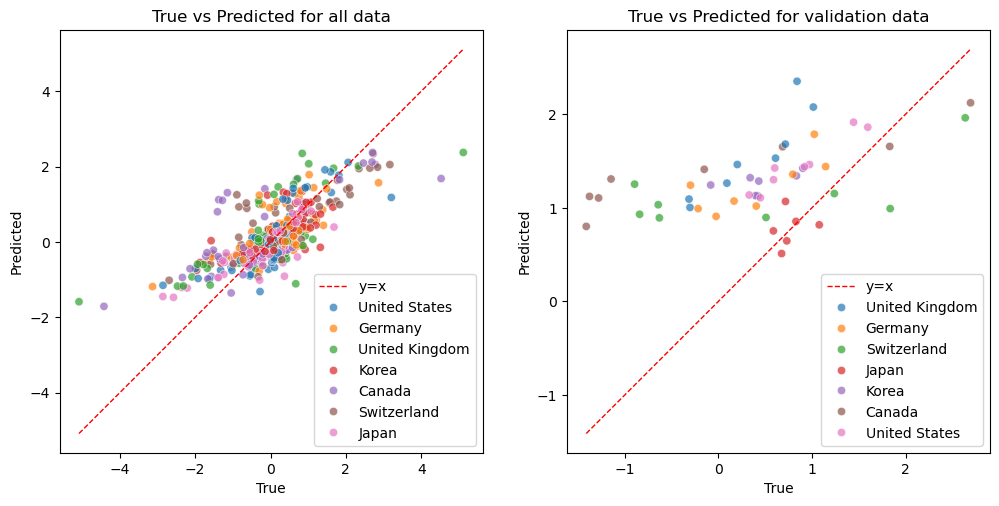

In [53]:
# Associate the result by country
y_pred_valid_country = pd.DataFrame({'date': X_valid['date'], 'country': country_valid, 'True GDP': y_valid, 'MLP': y_pred_valid})
y_pred_train_country = pd.DataFrame({'date': X_train['date'], 'country': country_train, 'True GDP': y_train, 'MLP': y_pred_train})

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_valid_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["True GDP", "MLP"],
    var_name="Type", value_name="Value"
)

def plot_predictions_against_true(true_key="True GDP", pred_key="y_pred"):
    plt.figure(figsize=(12, 6))

    ax = plt.subplot(1, 2, 1)
    ax.set_box_aspect(1)

    line_min = np.min([np.min(predictions[true_key]), np.min(predictions[pred_key])])
    line_max = np.max([np.max(predictions[true_key]), np.max(predictions[pred_key])])
    plt.plot([line_min, line_max], [line_min, line_max], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=predictions, hue='country', alpha=0.7)
    plt.title('True vs Predicted for all data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    ax.set_box_aspect(1)

    line_min = np.min([np.min(y_pred_valid_country[true_key]), np.min(y_pred_valid_country[pred_key])])
    line_max = np.max([np.max(y_pred_valid_country[true_key]), np.max(y_pred_valid_country[pred_key])])
    plt.plot([line_min, line_max], [line_min, line_max], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=y_pred_valid_country, hue='country', alpha=0.7)
    plt.title('True vs Predicted for validation data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    plt.show()

if not TEST_ALL_GT_DATA:
    print('MLP :')
    plot_predictions_against_true(true_key="True GDP", pred_key="MLP")

In [54]:
# Function to plot data with confidence intervals for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = filtered_data[filtered_data['Type'] == 'True GDP']['date'].quantile(TRAIN_PROPORTION)

    plt.figure(figsize=(12, 6))

    # Plot predictions and true values
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )

    # Add a vertical line to indicate where validation starts
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({(TRAIN_PROPORTION)*100:.0f}%)')

    # Enhancing the plot
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the updated plot function
interact(plot_by_country, selected_country=dropdown)

# Calculate Mean Squared Error
print(f"MLP : Training  MSE: {mean_squared_error(y_train, y_pred_train):.4f}", end="")
if not TEST_ALL_GT_DATA:
    print(f", Validation MSE: {mean_squared_error(y_valid, y_pred_valid):.4f}")
else:
    print()

interactive(children=(Dropdown(description='Country:', options=('United States', 'Germany', 'United Kingdom', …

MLP : Training  MSE: 0.3529, Validation MSE: 1.2783


# Converting to the original GDP values

In [55]:
# To use when the GDP is predicted on year-to-year log differences
def _reconstruct_gdp(y, y_mean, y_std, past_gdp):
    return np.exp(y * y_std + y_mean + np.log(past_gdp + 1)) - 1

def reconstruct_gdp(y, y_mean, y_std, past_gdps):
    y_shifted = y[4:]
    past_gdps = past_gdps[:-4]

    return np.array([_reconstruct_gdp(y_shifted[i], y_mean, y_std, past_gdps[i]) for i in range(len(y_shifted))])

def plot_reconstructed_gdp(country):    
    plt.figure(figsize=(12, 6))

    rkf = KF(seed=SEED)

    # Determine the number of samples
    nb_train_samples = X_train[country_train == country].shape[0]
    nb_samples = nb_train_samples + X_valid[country_valid == country].shape[0]
    nb_reconstructed_train_samples = nb_train_samples - 4
    nb_reconstructed_samples = nb_samples - 4

    # Get country GDPs
    sorted_gdps = all_gdps.sort_values('date')
    country_gdps = sorted_gdps.loc[sorted_gdps['country'] == country]['GDP'].values[-nb_samples:]
    
    # Predict with MLP
    MLP_train_pred = model.predict(X_train[country_train == country])
    MLP_valid_pred = model.predict(X_valid[country_valid == country])

    # Reconstruct GDPs
    reconstructed_predictions = {}
    reconstructed_predictions['MLP'] = reconstruct_gdp(
        np.concatenate([MLP_train_pred, MLP_valid_pred]), 
        y_mean, y_std, 
        country_gdps
    )

    # Smooth predictions with Kalman Filter
    rkf_train_pred = rkf.fit_predict(
        reconstructed_predictions['MLP'][:nb_reconstructed_train_samples], 
        country_gdps[:nb_reconstructed_train_samples], 
        np.repeat(country, len(MLP_train_pred) - 4)
    )
    rkf_valid_pred = rkf.predict(
        reconstructed_predictions['MLP'][-len(MLP_valid_pred):], 
        np.repeat(country, len(MLP_valid_pred))
    )
    reconstructed_predictions['rkf'] = np.concatenate([rkf_train_pred, rkf_valid_pred])

    # Plot results
    x_axis = pd.to_datetime(sorted_gdps.loc[sorted_gdps['country'] == country]['date']).values[-nb_reconstructed_samples:]
    cutoff_index = int(len(x_axis) * TRAIN_PROPORTION)
    cutoff_date = x_axis[cutoff_index]

    plt.plot(x_axis, reconstructed_predictions['MLP'], label='MLP', linestyle='-', marker='+')
    plt.plot(x_axis, reconstructed_predictions['rkf'], label='KF on recomputed GDP from MLP output', linestyle='-', marker='+')
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({(TRAIN_PROPORTION)*100:.0f}%)')
    plt.plot(x_axis, country_gdps[-nb_reconstructed_samples:], label='True GDP', linestyle='-', marker='o', markersize=3)
    plt.legend()
    plt.title('Predicted vs True GDP')  
    plt.xlabel('Time')
    plt.ylabel('GDP')
    plt.grid(True)
    plt.show()

# Dropdown for selecting country
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

if MODE == 'yearly-log-diff':
    interact(plot_reconstructed_gdp, country=dropdown)

interactive(children=(Dropdown(description='Country:', options=('United States', 'Germany', 'United Kingdom', …

In [56]:
import shap

PLOT_SHAP = True

if PLOT_SHAP:
    explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 20))
    shap_values = explainer(X_valid)
    shap.summary_plot(shap_values, X_valid)

/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


  0%|          | 0/53 [00:00<?, ?it/s]

/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/nathangr

KeyboardInterrupt: 